In [ ]:
"""
Author: sanskar khandelwal
Team Name: anndata
Team Members: thelastTransformer
Leaderboard Rank: 56
"""

# Soil Classification Pipeline

_In this notebook we combine a pretrained ResNet18 as a feature extractor with a Random Forest classifier to solve a soil type classification challenge._

## [1] Setup & Imports

- Import standard libraries (os, numpy, pandas, etc.).
- Set up PyTorch and check for GPU availability.
- Import vision and ML tools (torchvision, sklearn, PIL, albumentations).

In [11]:
# --- [1] Setup & Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from PIL import Image
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
from torchvision import models

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## [2] Paths & Data Loading

- Define the paths to train and test images.
- Load `train_labels.csv` and `test_ids.csv` into pandas DataFrames.
- Encode string labels into integers using `LabelEncoder`.


In [2]:
# --- [2] Paths & Data Loading ---
data_dir = "/kaggle/input/soil-classification/soil_classification-2025"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

train_csv = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))
test_csv = pd.read_csv(os.path.join(data_dir, "test_ids.csv"))

# Encode labels
le = LabelEncoder()
train_csv["label_encoded"] = le.fit_transform(train_csv["soil_type"])


## [3] Image Preprocessing & Augmentation

- Use Albumentations to build a transformation pipeline:
  - Resize images to 224×224.
  - Random horizontal flip and brightness/contrast adjustments.
  - Normalize with ImageNet statistics.
  - Convert to PyTorch tensor.
- Define `preprocess_image()` helper to read an image and apply transforms.

In [3]:
# --- [3] Image Preprocessing & Augmentation ---
# Use Albumentations for richer augmentations (installed in Kaggle env by default)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Compose transformation pipeline
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Helper to apply transform
def preprocess_image(path):
    image = np.array(Image.open(path).convert("RGB"))
    return transform(image=image)["image"]


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## [4] Feature Extraction using ResNet18

- Load pretrained ResNet-18 and strip off its final classification layer (`Identity` head).
- Move model to GPU (if available) and set to `eval()` mode.
- Define `extract_features()` which:
  1. Iterates through image paths.
  2. Applies preprocessing.
  3. Runs a forward pass (no grad) to get a feature vector.
  4. Returns an array of all features.

In [4]:
# --- [4] Feature Extraction using ResNet18 ---
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = torch.nn.Identity()  # Remove classification head
resnet = resnet.to(device)
resnet.eval()

def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting features"):
        img_tensor = preprocess_image(path).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = resnet(img_tensor).cpu().numpy().flatten()
        features.append(feat)
    return np.array(features)

train_paths = [os.path.join(train_dir, fname) for fname in train_csv['image_id']]
X = extract_features(train_paths)
y = train_csv['label_encoded'].values


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 
Extracting features: 100%|██████████| 1222/1222 [00:22<00:00, 55.35it/s]


## [5] Model Training with Stratified K-Fold

- Use `StratifiedKFold` (5 splits) to ensure balanced class distribution.
- For each fold:
  1. Train a `RandomForestClassifier` on the extracted features.
  2. Predict on the validation split.
  3. Compute and print macro F1-score and full classification report.
- Print the average F1-score over all folds.

In [5]:
# --- [5] Model Training with Stratified K-Fold ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")
    model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
    model.fit(X[train_idx], y[train_idx])
    
    preds = model.predict(X[val_idx])
    f1 = f1_score(y[val_idx], preds, average='macro')
    f1_scores.append(f1)
    
    print(f"Fold {fold+1} F1 Score: {f1:.4f}")
    print(classification_report(y[val_idx], preds, target_names=le.classes_))

print(f"\n✅ Average F1 Score: {np.mean(f1_scores):.4f}")



--- Fold 1 ---
Fold 1 F1 Score: 0.9173
               precision    recall  f1-score   support

Alluvial soil       0.93      0.96      0.94       106
   Black Soil       1.00      0.85      0.92        46
    Clay soil       0.83      0.88      0.85        40
     Red soil       0.94      0.96      0.95        53

     accuracy                           0.93       245
    macro avg       0.93      0.91      0.92       245
 weighted avg       0.93      0.93      0.93       245


--- Fold 2 ---
Fold 2 F1 Score: 0.9247
               precision    recall  f1-score   support

Alluvial soil       0.92      0.93      0.93       106
   Black Soil       0.95      0.89      0.92        47
    Clay soil       0.88      0.90      0.89        40
     Red soil       0.96      0.96      0.96        52

     accuracy                           0.93       245
    macro avg       0.93      0.92      0.92       245
 weighted avg       0.93      0.93      0.93       245


--- Fold 3 ---
Fold 3 F1 Score: 0

## [6] Final Training and Saving

- Retrain a `RandomForestClassifier` on the **entire** training set.
- Save the trained model (`final_model.pkl`) and the label classes (`label_classes.npy`) for later use.

In [6]:
# --- [6] Final Training and Saving ---
final_model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
final_model.fit(X, y)

joblib.dump(final_model, "final_model.pkl")
np.save("label_classes.npy", le.classes_)
print("✅ Final model and label classes saved.")


✅ Final model and label classes saved.


## [7] Inference & Submission

- Reload the saved model and label classes.
- Extract features on the test set.
- Predict soil types for all test images.
- Map integer predictions back to string labels.
- Build and save the Kaggle submission file (`submission.csv`).


🔁 Fold 1
               precision    recall  f1-score   support

Alluvial soil       0.93      0.94      0.93       106
   Black Soil       1.00      0.85      0.92        46
    Clay soil       0.88      0.88      0.88        40
     Red soil       0.88      0.96      0.92        53

     accuracy                           0.92       245
    macro avg       0.92      0.91      0.91       245
 weighted avg       0.92      0.92      0.92       245



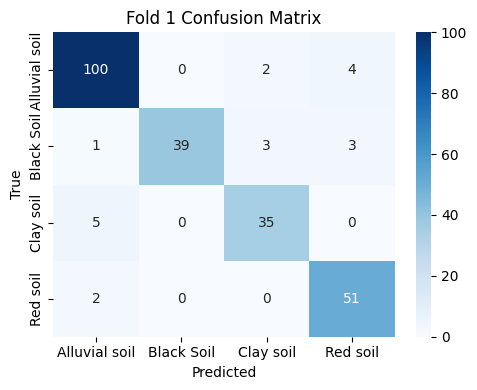


🔁 Fold 2
               precision    recall  f1-score   support

Alluvial soil       0.93      0.93      0.93       106
   Black Soil       0.95      0.89      0.92        47
    Clay soil       0.90      0.88      0.89        40
     Red soil       0.93      0.98      0.95        52

     accuracy                           0.93       245
    macro avg       0.93      0.92      0.92       245
 weighted avg       0.93      0.93      0.93       245



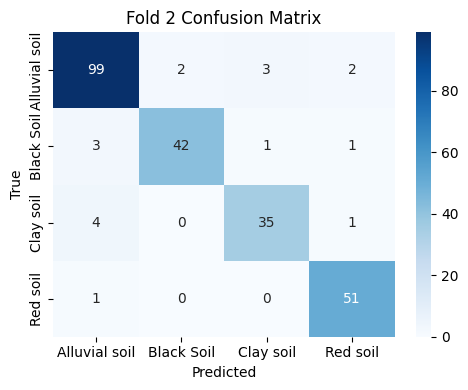


🔁 Fold 3
               precision    recall  f1-score   support

Alluvial soil       0.93      0.94      0.93       106
   Black Soil       0.96      0.93      0.95        46
    Clay soil       0.90      0.95      0.92        39
     Red soil       0.98      0.92      0.95        53

     accuracy                           0.94       244
    macro avg       0.94      0.94      0.94       244
 weighted avg       0.94      0.94      0.94       244



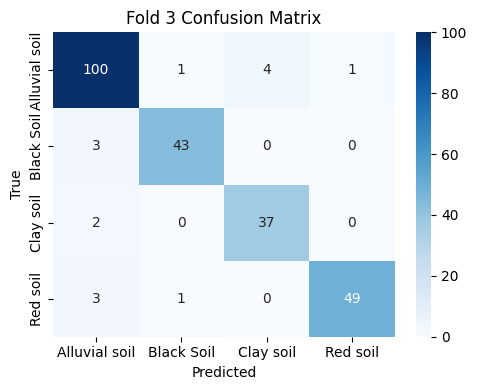


🔁 Fold 4
               precision    recall  f1-score   support

Alluvial soil       0.97      0.98      0.98       105
   Black Soil       0.96      0.96      0.96        46
    Clay soil       0.98      1.00      0.99        40
     Red soil       1.00      0.96      0.98        53

     accuracy                           0.98       244
    macro avg       0.98      0.97      0.98       244
 weighted avg       0.98      0.98      0.98       244



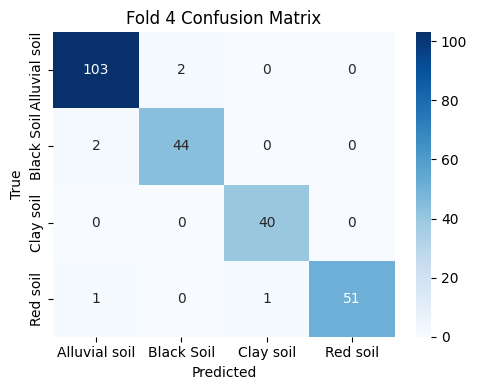


🔁 Fold 5
               precision    recall  f1-score   support

Alluvial soil       0.95      0.98      0.97       105
   Black Soil       1.00      0.91      0.95        46
    Clay soil       0.97      0.97      0.97        40
     Red soil       0.98      1.00      0.99        53

     accuracy                           0.97       244
    macro avg       0.98      0.97      0.97       244
 weighted avg       0.97      0.97      0.97       244



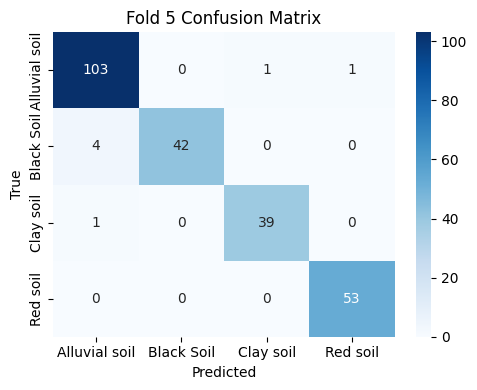


✅ Average F1-score: 0.9441


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


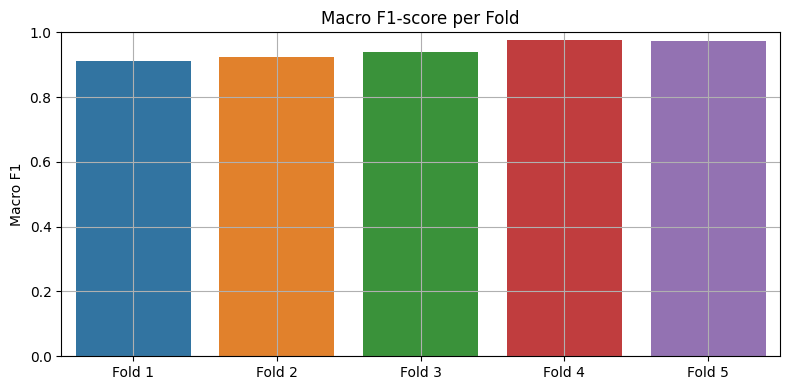

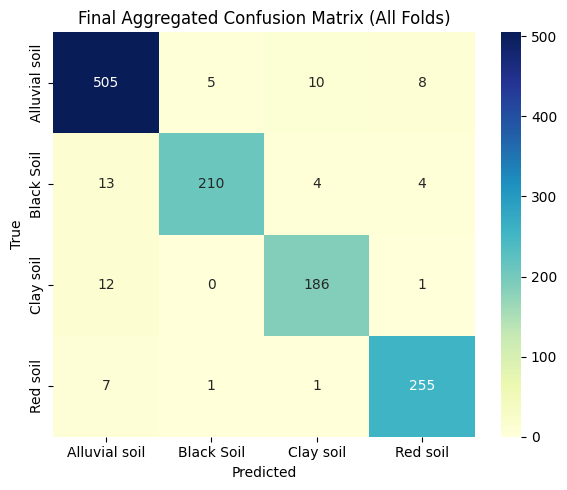

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Redefine everything in case session restarted
fold_scores = []
all_val_preds = []
all_val_targets = []
fold_reports = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}")
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
    clf.fit(X[train_idx], y[train_idx])
    
    val_preds = clf.predict(X[val_idx])
    val_targets = y[val_idx]
    
    all_val_preds.extend(val_preds)
    all_val_targets.extend(val_targets)
    
    f1 = f1_score(val_targets, val_preds, average='macro')
    fold_scores.append(f1)

    # Classification report
    print(classification_report(val_targets, val_preds, target_names=le.classes_))
    
    # Confusion matrix
    cm = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(f"Fold {fold+1} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# 🔥 Overall metrics
print(f"\n✅ Average F1-score: {np.mean(fold_scores):.4f}")

# 🔷 Plot F1-score per fold
plt.figure(figsize=(8, 4))
sns.barplot(x=[f"Fold {i+1}" for i in range(len(fold_scores))], y=fold_scores)
plt.title("Macro F1-score per Fold")
plt.ylim(0, 1)
plt.ylabel("Macro F1")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔷 Final confusion matrix (aggregated)
final_cm = confusion_matrix(all_val_targets, all_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="YlGnBu")
plt.title("Final Aggregated Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [8]:
# --- [7] Inference ---
# Reload model and label encoder
model = joblib.load("final_model.pkl")
label_classes = np.load("label_classes.npy", allow_pickle=True)


test_paths = [os.path.join(test_dir, fname) for fname in test_csv['image_id']]
X_test = extract_features(test_paths)

# Predict
test_preds = model.predict(X_test)
test_labels = [label_classes[p] for p in test_preds]

# Submission CSV
submission_df = pd.DataFrame({
    "image_id": test_csv["image_id"],
    "soil_type": test_labels
})
submission_df.to_csv("submission.csv", index=False)
print("✅ submission_task1.csv saved.")


Extracting features: 100%|██████████| 341/341 [00:05<00:00, 64.55it/s]


✅ submission_task1.csv saved.
